# Preprocessing

In [55]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import plotly.express as px
from configuration.config import DATA_PATH

MODELING_PATH = os.path.join(DATA_PATH, 'modeling')

In [57]:
df = pd.read_csv(DATA_PATH +'data_new_features.csv')

In [58]:
pd.set_option('display.max_columns', None)
df.head()

,BHCMISID,HealthCenterName,HealthCenterState,FundingCHC,FundingMHC,FundingHO,FundingPH,UrbanRuralFlag,total_hc_funding,total_other_revenue,hispanic_any_race,total_patients,lep_patients,medicare_18_up,migrant_patients,homeless_patients,school_based_patients,veteran_patients,public_housing_patients,total_cost_care,total_sfs,enabling_patients,ZipCode_Count,SiteCity_Count,SiteState_Count,TotalWeeklyHoursOfOperation,total_grant_funding,grants_to_rev_ratio,high_other_revenue,other_revenue_category,diverse_patients_sum,diverse_race_proportion,hispanic_proportion,low_income,uninsured,medicaid,public_insurance,private_insurance,poverty_ratio,total_0_17_ratio,total_18_up_ratio,lep_patients_ratio,fpl_100_below_ratio,low_income_ratio,uninsured_ratio,medicaid_ratio,medicare_18_up_ratio,public_insurance_ratio,private_insurance_ratio,migrant_patients_ratio,homeless_patients_ratio,school_based_patients_ratio,veteran_patients_ratio,public_housing_patients_ratio,diverse_race_proportion_bins,hispanic_proportion_bins,low_income_ratio_bins,poverty_ratio_bins,medicaid_ratio_bins,lep_patients_ratio_bins,private_insurance_ratio_bins,uninsured_ratio_bins,medicare_18_up_ratio_bins,homeless_patients_ratio_above_median,veteran_patients_ratio_above_median,public_housing_patients_ratio_above_median,migrant_patients_ratio_above_median,school_based_patients_ratio_above_median,public_insurance_ratio_above_median,total_enabling_visits,total_visits,total_sites,ops_confidential,fin_confidential
0,010030,"HOLYOKE HEALTH CENTER, INC.",MA,True,False,False,False,Urban,5721128,14258919,12631,19144,8371,3320,45,2998,0,332,19144,NaN,NaN,NaN,50,3,1,175.0,6112612,0.27036,1,1M to 30M,650,0.033953,0.659789,2993,713,13520,13,1576,0.141350,0.269379,0.730621,0.437265,0.141350,0.156341,0.037244,0.706226,0.173422,0.000679,0.082323,0.002351,0.156603,0.000000,0.017342,1.000000,Q1,Q4,Q1,Q1,Q4,Q4,Q1,Q1,Q4,1,1,1,0,0,1,NaN,NaN,4,1,1
1,010040,MAINE MOBILE HEALTH PROGRAM INC.,ME,False,True,False,False,Rural,1758567,36578,471,850,654,13,769,11,0,4,0,2183264.0,617158.0,263.0,24,2,1,195.0,525083,0.93488,0,Less than 100K,348,0.409412,0.554118,844,769,60,0,30,0.903529,0.075294,0.924706,0.769412,0.903529,0.992941,0.904706,0.070588,0.015294,0.000000,0.035294,0.904706,0.012941,0.000000,0.004706,0.000000,Q4,Q4,Q4,Q4,Q1,Q4,Q1,Q4,Q1,0,0,0,1,0,0,629.0,2573.0,6,0,0
2,010060,"FAIR HAVEN COMMUNITY HEALTH CLINIC, INC.",CT,True,False,False,False,Urban,4569124,270649,19204,31918,12686,1686,14,208,1937,24,29342,33153465.0,1716660.0,3539.0,62,3,1,603.0,4006086,0.89113,1,100K to 1M,7906,0.247697,0.601667,18781,4467,22313,0,3451,0.411617,0.606805,0.393195,0.397456,0.411617,0.588414,0.139952,0.699073,0.052823,0.000000,0.108121,0.000439,0.006517,0.060687,0.000752,0.919293,Q3,Q4,Q2,Q2,Q4,Q4,Q1,Q2,Q1,0,0,1,0,1,0,6151.0,124280.0,17,0,0
3,010070,CORNELL SCOTT HILL HEALTH CORPORATION,CT,True,False,True,True,Urban,6160674,1753132,19860,52434,12197,3210,16,2206,2125,196,14603,NaN,NaN,NaN,116,5,1,1206.0,9298309,0.82119,1,1M to 30M,18713,0.356887,0.378762,28361,5438,32596,0,11188,0.432982,0.154976,0.845024,0.232616,0.432982,0.540889,0.103711,0.621658,0.061220,0.000000,0.213373,0.000305,0.042072,0.040527,0.003738,0.278502,Q3,Q3,Q2,Q3,Q4,Q3,Q3,Q2,Q1,1,0,1,0,1,0,NaN,NaN,37,1,1
4,010120,"CITY OF SPRINGFIELD, MASSACHUSETTS",MA,False,False,True,False,Urban,1842241,0,857,2055,461,295,85,1747,0,57,0,2684614.0,8876.0,1140.0,21,4,1,158.0,200000,0.95955,0,Zero,496,0.241363,0.417032,1383,331,1357,0,72,0.628224,0.017518,0.982482,0.224331,0.628224,0.672993,0.161071,0.660341,0.143552,0.000000,0.035036,0.041363,0.850122,0.000000,0.027737,0.000000,Q3,Q3,Q3,Q4,Q4,Q3,Q1,Q2,Q3,1,1,0,1,0,0,3100.0,9538.0,10,0,0


# Overview of Preprocessing Strategy

My first step is to transform all data into numerical data that can be processed and analyzed by various ML models. 

### Steps to take for preprocessing

**1. Transform data so that it only contains numerical information**
* Drop the identifier columns `BHMISID` and `HealthCenterName` as they are not needed at this point in time.
* Encode the `HealthCenterState` using frequency encoding. I am choosing this method because the states may influence funding levels. More funding gets allocated to states with higher populations, so to preserve this importance, I am going to use a frequency encoding technique. 
* Encode the Funding-Type columns from boolean to integers.
* Dummy encode the `UrbanRuralFlag` and `other_revenue_category` columns

**2. Split the data into train and test sets**

**3. Deal with missing values**

The dataset contains 5 columns with missing values, about 43% of the observations are missing. The columns are identified below. This data is not missing at random. Health centers have opted to keep this information confidential. In order to take a comprehensive approach to handling this for modeling, I created indicator columns to identify which observations opted to withhold these data. `ops_confidential` identifies entities that withheld oeprations data (visits and patient counts by visit type). `fin_confidential` identifies entities that withheld financial data (costs of care and sliding fee scale details).

For modeling, I will have two train/test splits:

* *Split 1:* Does not include the columns with missing values, but will include the missing indicator columns. 
* *Split 2:* Missing values will be imputed with MICE imputation and will also include the missing indicator columns. 

I will evaluate each of the train/test splits to see if models perform better with removed columns or imputed data.

**4. Scale the data**

In order to scale the data, I will need to consider strategies to deal with outliers. The outliers in the data are not due to errors. Some health centers have much larger operations, so it is expected to see skewed results for many features. Because these outliers may provide valuable insights, I will want to evaluate models that include them. However, these outliers may prove to be problematic and I may need to transform the data to reduce the impact of outliers. I will use two different scaling techniques and evaluate models on both:

* RobustScaler(): This scaler is less sensitive to outliers, and will scales data according to the median and the interquartile range. This will reduce the influence of extreme outliers in the data. 
* PowerTransformer(): This scaler applies transformations that reduce the impact of outliers. Log transformation, square root, or Box-Cox transformations can help reduce the variance and effect of extreme values.

Each scaler will be applied to each of the train/test splits. 

The result will be 4 sets of train/test data to use for modeling. 

In [59]:
# drop columns for feature engineering
df = df.drop(columns=['BHCMISID', 'HealthCenterName'])

In [60]:
# Find columns that end with '_ratio'
bins_columns = df.filter(regex='_bins$').columns
median_columns = df.filter(regex='_above_median$').columns

# Drop these columns
df = df.drop(bins_columns, axis=1)
df = df.drop(median_columns, axis=1)

In [61]:
# encode health center states by using frequency counts for each state
state_frequency = df['HealthCenterState'].value_counts()
df['state_freq_enc'] = df['HealthCenterState'].map(state_frequency)

# drop HealthCenterState column
df.drop(columns='HealthCenterState', inplace=True)

In [62]:
def convert_bool_numeric(df, col_list):
    """
    Converts columns specified in col_list from boolean to integer type within the given DataFrame.
    
    This function iterates over a list of columns in a DataFrame that are currently of boolean type 
    and converts each of them to an integer type, where True becomes 1 and False becomes 0. 
    This is particularly useful for preparing data for machine learning models that require 
    numerical input features.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the columns to convert.
    col_list (list of str): A list of column names in the DataFrame that are to be converted from boolean to integer.

    Returns:
    None: Modifies the DataFrame in-place; does not return anything.
    """
    for col in col_list:
        df[col] = df[col].astype('int')

In [63]:
# convert boolean columns to integers
convert_bool_numeric(df, ['FundingCHC', 'FundingMHC', 'FundingHO', 'FundingPH'])


In [64]:
df.head()

,FundingCHC,FundingMHC,FundingHO,FundingPH,UrbanRuralFlag,total_hc_funding,total_other_revenue,hispanic_any_race,total_patients,lep_patients,medicare_18_up,migrant_patients,homeless_patients,school_based_patients,veteran_patients,public_housing_patients,total_cost_care,total_sfs,enabling_patients,ZipCode_Count,SiteCity_Count,SiteState_Count,TotalWeeklyHoursOfOperation,total_grant_funding,grants_to_rev_ratio,high_other_revenue,other_revenue_category,diverse_patients_sum,diverse_race_proportion,hispanic_proportion,low_income,uninsured,medicaid,public_insurance,private_insurance,poverty_ratio,total_0_17_ratio,total_18_up_ratio,lep_patients_ratio,fpl_100_below_ratio,low_income_ratio,uninsured_ratio,medicaid_ratio,medicare_18_up_ratio,public_insurance_ratio,private_insurance_ratio,migrant_patients_ratio,homeless_patients_ratio,school_based_patients_ratio,veteran_patients_ratio,public_housing_patients_ratio,total_enabling_visits,total_visits,total_sites,ops_confidential,fin_confidential,state_freq_enc
0,1,0,0,0,Urban,5721128,14258919,12631,19144,8371,3320,45,2998,0,332,19144,NaN,NaN,NaN,50,3,1,175.0,6112612,0.27036,1,1M to 30M,650,0.033953,0.659789,2993,713,13520,13,1576,0.141350,0.269379,0.730621,0.437265,0.141350,0.156341,0.037244,0.706226,0.173422,0.000679,0.082323,0.002351,0.156603,0.000000,0.017342,1.000000,NaN,NaN,4,1,1,37
1,0,1,0,0,Rural,1758567,36578,471,850,654,13,769,11,0,4,0,2183264.0,617158.0,263.0,24,2,1,195.0,525083,0.93488,0,Less than 100K,348,0.409412,0.554118,844,769,60,0,30,0.903529,0.075294,0.924706,0.769412,0.903529,0.992941,0.904706,0.070588,0.015294,0.000000,0.035294,0.904706,0.012941,0.000000,0.004706,0.000000,629.0,2573.0,6,0,0,18
2,1,0,0,0,Urban,4569124,270649,19204,31918,12686,1686,14,208,1937,24,29342,33153465.0,1716660.0,3539.0,62,3,1,603.0,4006086,0.89113,1,100K to 1M,7906,0.247697,0.601667,18781,4467,22313,0,3451,0.411617,0.606805,0.393195,0.397456,0.411617,0.588414,0.139952,0.699073,0.052823,0.000000,0.108121,0.000439,0.006517,0.060687,0.000752,0.919293,6151.0,124280.0,17,0,0,16
3,1,0,1,1,Urban,6160674,1753132,19860,52434,12197,3210,16,2206,2125,196,14603,NaN,NaN,NaN,116,5,1,1206.0,9298309,0.82119,1,1M to 30M,18713,0.356887,0.378762,28361,5438,32596,0,11188,0.432982,0.154976,0.845024,0.232616,0.432982,0.540889,0.103711,0.621658,0.061220,0.000000,0.213373,0.000305,0.042072,0.040527,0.003738,0.278502,NaN,NaN,37,1,1,16
4,0,0,1,0,Urban,1842241,0,857,2055,461,295,85,1747,0,57,0,2684614.0,8876.0,1140.0,21,4,1,158.0,200000,0.95955,0,Zero,496,0.241363,0.417032,1383,331,1357,0,72,0.628224,0.017518,0.982482,0.224331,0.628224,0.672993,0.161071,0.660341,0.143552,0.000000,0.035036,0.041363,0.850122,0.000000,0.027737,0.000000,3100.0,9538.0,10,0,0,37


In [65]:
# dummy encode UrbanRuralFlag column and drop it from the df
df = pd.get_dummies(df, dtype=int, drop_first=True)

In [66]:
# dummy encode other_revenue_category column and drop it from the df
health_centers_clean = df

In [67]:
health_centers_clean.head()

,FundingCHC,FundingMHC,FundingHO,FundingPH,total_hc_funding,total_other_revenue,hispanic_any_race,total_patients,lep_patients,medicare_18_up,migrant_patients,homeless_patients,school_based_patients,veteran_patients,public_housing_patients,total_cost_care,total_sfs,enabling_patients,ZipCode_Count,SiteCity_Count,SiteState_Count,TotalWeeklyHoursOfOperation,total_grant_funding,grants_to_rev_ratio,high_other_revenue,diverse_patients_sum,diverse_race_proportion,hispanic_proportion,low_income,uninsured,medicaid,public_insurance,private_insurance,poverty_ratio,total_0_17_ratio,total_18_up_ratio,lep_patients_ratio,fpl_100_below_ratio,low_income_ratio,uninsured_ratio,medicaid_ratio,medicare_18_up_ratio,public_insurance_ratio,private_insurance_ratio,migrant_patients_ratio,homeless_patients_ratio,school_based_patients_ratio,veteran_patients_ratio,public_housing_patients_ratio,total_enabling_visits,total_visits,total_sites,ops_confidential,fin_confidential,state_freq_enc,UrbanRuralFlag_Urban,other_revenue_category_1M to 30M,other_revenue_category_Less than 100K,other_revenue_category_Over 30M,other_revenue_category_Zero
0,1,0,0,0,5721128,14258919,12631,19144,8371,3320,45,2998,0,332,19144,NaN,NaN,NaN,50,3,1,175.0,6112612,0.27036,1,650,0.033953,0.659789,2993,713,13520,13,1576,0.141350,0.269379,0.730621,0.437265,0.141350,0.156341,0.037244,0.706226,0.173422,0.000679,0.082323,0.002351,0.156603,0.000000,0.017342,1.000000,NaN,NaN,4,1,1,37,1,1,0,0,0
1,0,1,0,0,1758567,36578,471,850,654,13,769,11,0,4,0,2183264.0,617158.0,263.0,24,2,1,195.0,525083,0.93488,0,348,0.409412,0.554118,844,769,60,0,30,0.903529,0.075294,0.924706,0.769412,0.903529,0.992941,0.904706,0.070588,0.015294,0.000000,0.035294,0.904706,0.012941,0.000000,0.004706,0.000000,629.0,2573.0,6,0,0,18,0,0,1,0,0
2,1,0,0,0,4569124,270649,19204,31918,12686,1686,14,208,1937,24,29342,33153465.0,1716660.0,3539.0,62,3,1,603.0,4006086,0.89113,1,7906,0.247697,0.601667,18781,4467,22313,0,3451,0.411617,0.606805,0.393195,0.397456,0.411617,0.588414,0.139952,0.699073,0.052823,0.000000,0.108121,0.000439,0.006517,0.060687,0.000752,0.919293,6151.0,124280.0,17,0,0,16,1,0,0,0,0
3,1,0,1,1,6160674,1753132,19860,52434,12197,3210,16,2206,2125,196,14603,NaN,NaN,NaN,116,5,1,1206.0,9298309,0.82119,1,18713,0.356887,0.378762,28361,5438,32596,0,11188,0.432982,0.154976,0.845024,0.232616,0.432982,0.540889,0.103711,0.621658,0.061220,0.000000,0.213373,0.000305,0.042072,0.040527,0.003738,0.278502,NaN,NaN,37,1,1,16,1,1,0,0,0
4,0,0,1,0,1842241,0,857,2055,461,295,85,1747,0,57,0,2684614.0,8876.0,1140.0,21,4,1,158.0,200000,0.95955,0,496,0.241363,0.417032,1383,331,1357,0,72,0.628224,0.017518,0.982482,0.224331,0.628224,0.672993,0.161071,0.660341,0.143552,0.000000,0.035036,0.041363,0.850122,0.000000,0.027737,0.000000,3100.0,9538.0,10,0,0,37,1,0,0,0,1


In [68]:
health_centers_clean[['total_hc_funding']].describe().apply(lambda x: x.apply('{0:.2f}'.format))

,total_hc_funding
count,1340.00
mean,3671710.91
std,2743608.67
min,275778.00
25%,1803810.00
50%,2862998.00
75%,4611892.25
max,22382349.00


In [69]:
def identify_outliers(df, col):
    """
    Calculate the upper and lower bounds to identify outliers in a dataset.

    This function uses the Interquartile Range (IQR) to determine outliers. It computes the IQR for a specified column
    of a pandas DataFrame, and uses this to calculate boundaries that define outliers. Values falling outside of these
    boundaries are considered outliers.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data to analyze.
    col (str): The name of the column in the DataFrame for which to calculate the outlier bounds.

    Returns:
    tuple: A tuple containing three elements:
        - upper_bound (float): The upper bound value beyond which data points are considered outliers.
        - lower_bound (float): The lower bound value below which data points are considered outliers.
        - iqr (float): The Interquartile Range (IQR) of the column.
        """
    
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1

    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr

    return upper_bound, lower_bound, iqr

In [70]:
upper_bound_funding, lower_bound_funding, iqr = identify_outliers(df, 'total_hc_funding')

In [71]:
upper_bound_funding, lower_bound_funding, iqr

(8824015.625, -2408313.375, 2808082.25)

In [72]:
df[df['total_hc_funding'] < df['total_hc_funding'].quantile(0.25)][['total_hc_funding']].describe().apply(lambda x: x.apply('{0:.2f}'.format))

,total_hc_funding
count,335.00
mean,1299891.86
std,349657.26
min,275778.00
25%,1056662.50
50%,1372429.00
75%,1584693.50
max,1801620.00


In [73]:
print(df['total_hc_funding'].quantile(0.95))

8787824.95


In [148]:
bins = [200_000, 1_000_000, 1_800_000, 2_600_000, 3_400_000, 4_200_000, 5_000_000, 8_700_000, float('inf')]
labels = ['200K - 1M', '1M - 1.8M', '1.8M - 2.6M', '2.6M - 3.4M', '3.4M - 4.2M', '4.2M - 5M', '5M - 8.7M', 'Outlier']

health_centers_clean['total_funding_bins'] = pd.cut(df['total_hc_funding'], bins=bins, labels=labels)

In [149]:
health_centers_clean[['total_funding_bins']].value_counts()

total_funding_bins
1M - 1.8M             265
1.8M - 2.6M           247
5M - 8.7M             223
2.6M - 3.4M           215
3.4M - 4.2M           153
4.2M - 5M              98
Outlier                70
200K - 1M              69
Name: count, dtype: int64

## Splitting data into train and test sets

In [150]:
from sklearn.model_selection import train_test_split

In [151]:
X = health_centers_clean.drop(columns=['total_hc_funding', 'total_funding_bins'])
y = health_centers_clean[['total_funding_bins']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=48)

In [152]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(938, 59) (402, 59) (938, 1) (402, 1)


<Axes: xlabel='total_funding_bins', ylabel='Count'>

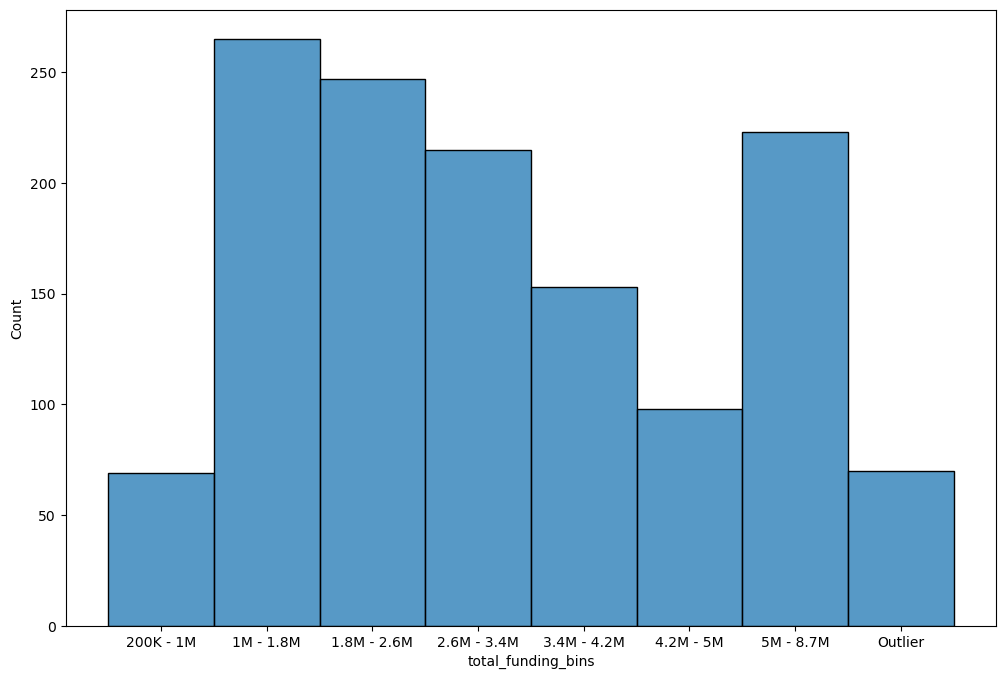

In [153]:
fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(df['total_funding_bins'])

## Handling missing values in train and test splits

Below I want to verify that the train and test splits have similar percentages of missing data. 

In [154]:
missing_proportion = X_train.isna().sum().reset_index()
missing_proportion.columns = ['column', 'missing']
missing_proportion.sort_values('missing', ascending=False)
missing_proportion['perc_missing'] = round(missing_proportion['missing'] / len(X_train) * 100, 2)
missing_df_train = missing_proportion[missing_proportion['perc_missing'] > 0]
missing_df_train


,column,missing,perc_missing
14,total_cost_care,440,46.91
15,total_sfs,437,46.59
16,enabling_patients,404,43.07
48,total_enabling_visits,404,43.07
49,total_visits,404,43.07


In [155]:
missing_proportion = X_test.isna().sum().reset_index()
missing_proportion.columns = ['column', 'missing']
missing_proportion.sort_values('missing', ascending=False)
missing_proportion['perc_missing'] = round(missing_proportion['missing'] / len(X_test) * 100, 2)
missing_df_test = missing_proportion[missing_proportion['perc_missing'] > 0]
missing_df_test


,column,missing,perc_missing
14,total_cost_care,170,42.29
15,total_sfs,175,43.53
16,enabling_patients,157,39.05
48,total_enabling_visits,157,39.05
49,total_visits,157,39.05


### Removing columns with missing data but keeping missingness indicator columns

In [156]:
cols_to_drop = ['total_cost_care', 'total_sfs', 'enabling_patients', 'total_enabling_visits', 'total_visits']
X_train_reduced = X_train.drop(columns=cols_to_drop)
X_test_reduced = X_test.drop(columns=cols_to_drop)

# Scaling data

In [157]:
from sklearn.preprocessing import RobustScaler, PowerTransformer

robust_scaler = RobustScaler()
power_transformer = PowerTransformer()


### Visualizing difference between scaling methods

I want to isolate a couple of columns to visualize how each scaler will transform the data.

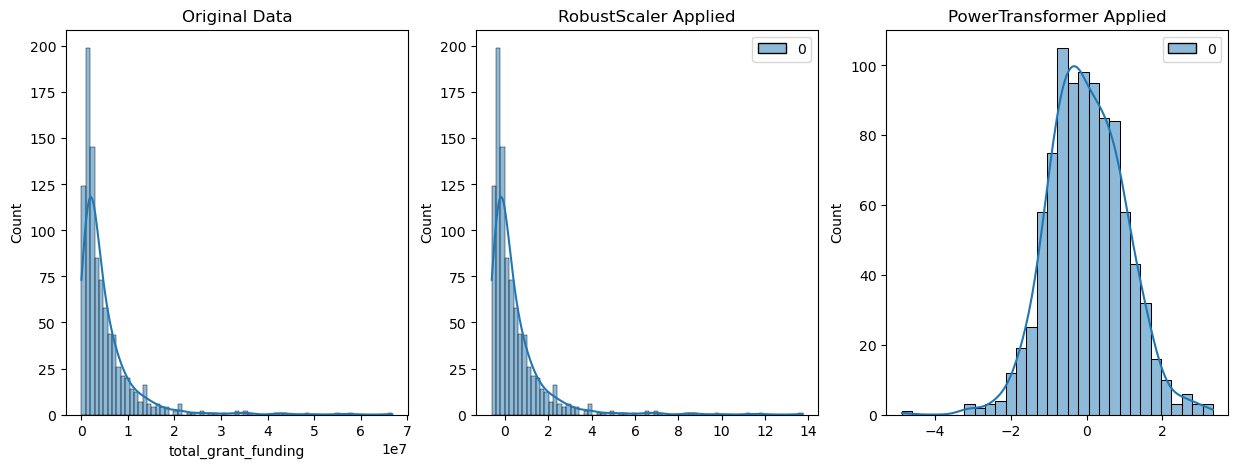

In [158]:
X_train_reduced_scaled = robust_scaler.fit_transform(X_train_reduced[['total_grant_funding']])
X_train_reduced_scaled_p = power_transformer.fit_transform(X_train_reduced[['total_grant_funding']])


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(X_train_reduced['total_grant_funding'], ax=ax[0], kde=True)
ax[0].set_title('Original Data')
sns.histplot(X_train_reduced_scaled, ax=ax[1], kde=True)
ax[1].set_title('RobustScaler Applied')
sns.histplot(X_train_reduced_scaled_p, ax=ax[2], kde=True)
ax[2].set_title('PowerTransformer Applied')
plt.show()

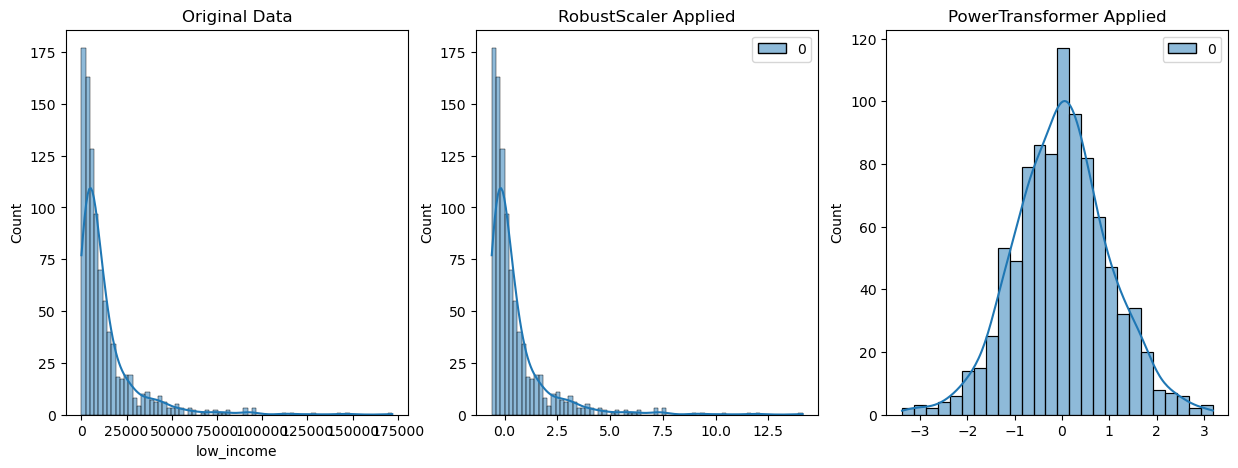

In [159]:
X_train_reduced_scaled = robust_scaler.fit_transform(X_train_reduced[['low_income']])
X_train_reduced_scaled_p = power_transformer.fit_transform(X_train_reduced[['low_income']])


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(X_train_reduced['low_income'], ax=ax[0], kde=True)
ax[0].set_title('Original Data')
sns.histplot(X_train_reduced_scaled, ax=ax[1], kde=True)
ax[1].set_title('RobustScaler Applied')
sns.histplot(X_train_reduced_scaled_p, ax=ax[2], kde=True)
ax[2].set_title('PowerTransformer Applied')
plt.show()

RobustScaler() keeps the features's original shape, including outliers while PowerTransformer() seems to normalize the features. 

## RobustScaler() Method

### RobustScaler with Reduced Data

In [160]:
robust_scaler.fit(X_train_reduced)
X_train_reduced_robust = robust_scaler.transform(X_train_reduced)
X_test_reduced_robust = robust_scaler.transform(X_test_reduced)

# PowerTransformer() Method

### PowerTransformer() with Reduced Data

In [161]:
power_transformer.fit(X_train_reduced)
X_train_reduced_power = power_transformer.transform(X_train_reduced)
X_test_reduced_power = power_transformer.transform(X_test_reduced)

## Saving files

In [162]:
# Set 1: Reduced datasets scaled with RobustScaler
dict_reduced_robust_c = {
    'X_train_rr_c': X_train_reduced_robust,
    'X_test_rr_c': X_test_reduced_robust,
    'y_train_c': y_train,
    'y_test_c': y_test
}

# Set 3: Reduced datasets scaled with PowerTransformer
dict_reduced_power_c= {
    'X_train_rp_c': X_train_reduced_power,
    'X_test_rp_c': X_test_reduced_power,
    'y_train_c': y_train,
    'y_test_c': y_test
}

columns = X_train_reduced.columns.to_list()

In [163]:
def save_files(data_dict, columns, data_path):
    """
    Saves training and testing data to CSV files in the specified directory using names derived from the data dictionary keys.
    
    Parameters:
    - data_dict: Dictionary with keys as intended file names and values as the data (Numpy array or DataFrame).
    - columns: List of column names for the features, applicable if data values are Numpy arrays.
    - data_path: Path to the directory where files will be saved.
    """
    # Ensure the directory exists
    os.makedirs(data_path, exist_ok=True)
    
    # Iterate through the dictionary items
    for dataset_name, data in data_dict.items():
        # Determine if the data is a DataFrame or needs conversion
        if isinstance(data, pd.DataFrame):
            df = data
        else:
            df = pd.DataFrame(data, columns=columns)
        
        # Construct file path
        file_path = os.path.join(data_path, f'{dataset_name}.csv')
        
        # Save the DataFrame to a CSV file
        df.to_csv(file_path, index=False)
        print(f"File saved successfully: {file_path}")

In [164]:
save_files(dict_reduced_robust_c, columns, MODELING_PATH)
save_files(dict_reduced_power_c, columns, MODELING_PATH)


File saved successfully: /Users/katialopes-gilbert/repos/capstone-project-fqhc-model/data/modeling/X_train_rr_c.csv
File saved successfully: /Users/katialopes-gilbert/repos/capstone-project-fqhc-model/data/modeling/X_test_rr_c.csv
File saved successfully: /Users/katialopes-gilbert/repos/capstone-project-fqhc-model/data/modeling/y_train_c.csv
File saved successfully: /Users/katialopes-gilbert/repos/capstone-project-fqhc-model/data/modeling/y_test_c.csv
File saved successfully: /Users/katialopes-gilbert/repos/capstone-project-fqhc-model/data/modeling/X_train_rp_c.csv
File saved successfully: /Users/katialopes-gilbert/repos/capstone-project-fqhc-model/data/modeling/X_test_rp_c.csv
File saved successfully: /Users/katialopes-gilbert/repos/capstone-project-fqhc-model/data/modeling/y_train_c.csv
File saved successfully: /Users/katialopes-gilbert/repos/capstone-project-fqhc-model/data/modeling/y_test_c.csv
